STEP 1: Loading Data
Raw dataset shape: (400, 18)
Columns: ['S.No.', 'Name', 'P/E', 'Mar Cap\xa0Rs.Cr.\xa0', 'Div Yld\xa0%', 'NP Qtr\xa0Rs.Cr.', 'Qtr Profit Var\xa0%', 'Sales Qtr\xa0Rs.Cr.', 'Qtr Sales Var\xa0%', 'ROCE\xa0%', 'OPM\xa0%', 'Sales Var 3Yrs\xa0%', 'Profit Var 3Yrs\xa0%', '3Yrs return\xa0%', 'ROE 3Yr\xa0%', 'EBIDT Var 3Yrs\xa0%', 'EPS Var 3Yrs\xa0%', 'Sector']

First 3 rows:
   S.No.              Name    P/E  Mar Cap Rs.Cr.   Div Yld %  NP Qtr Rs.Cr.  \
0      1    L&T Technology  36.14         46182.44       1.26         329.20   
1      2  Inventurus Knowl  46.64         28437.69       0.00         180.72   
2      3   Tata Technolog.  38.19         26478.92       1.28         165.50   

   Qtr Profit Var %  Sales Qtr Rs.Cr.  Qtr Sales Var %  ROCE %  OPM %  \
0              2.85           2979.50            15.80   28.29  16.75   
1             59.93            781.09            21.52   27.20  31.55   
2              5.14           1323.33             2.07   25.80  16.93 

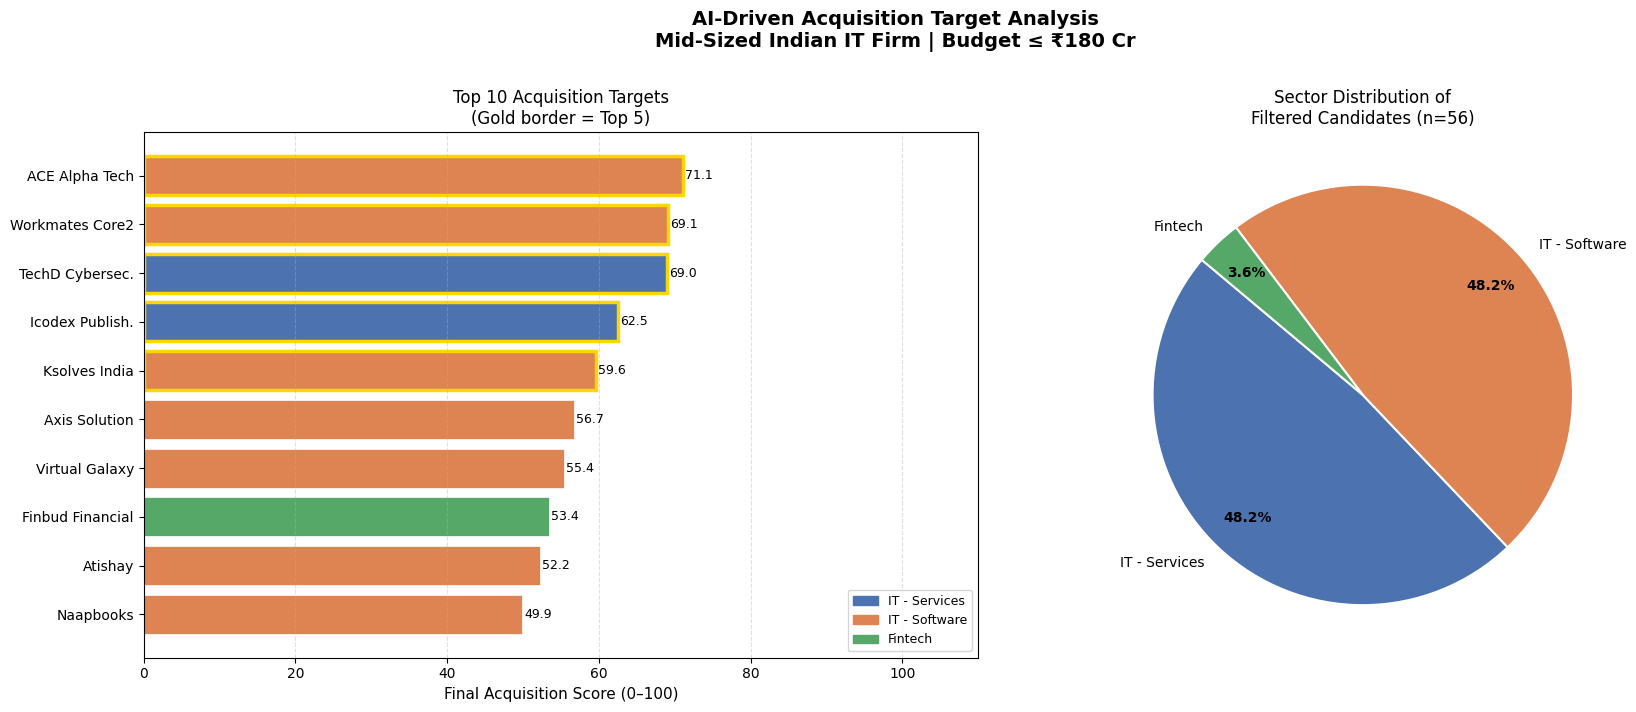

Chart saved: acquisition_analysis.png


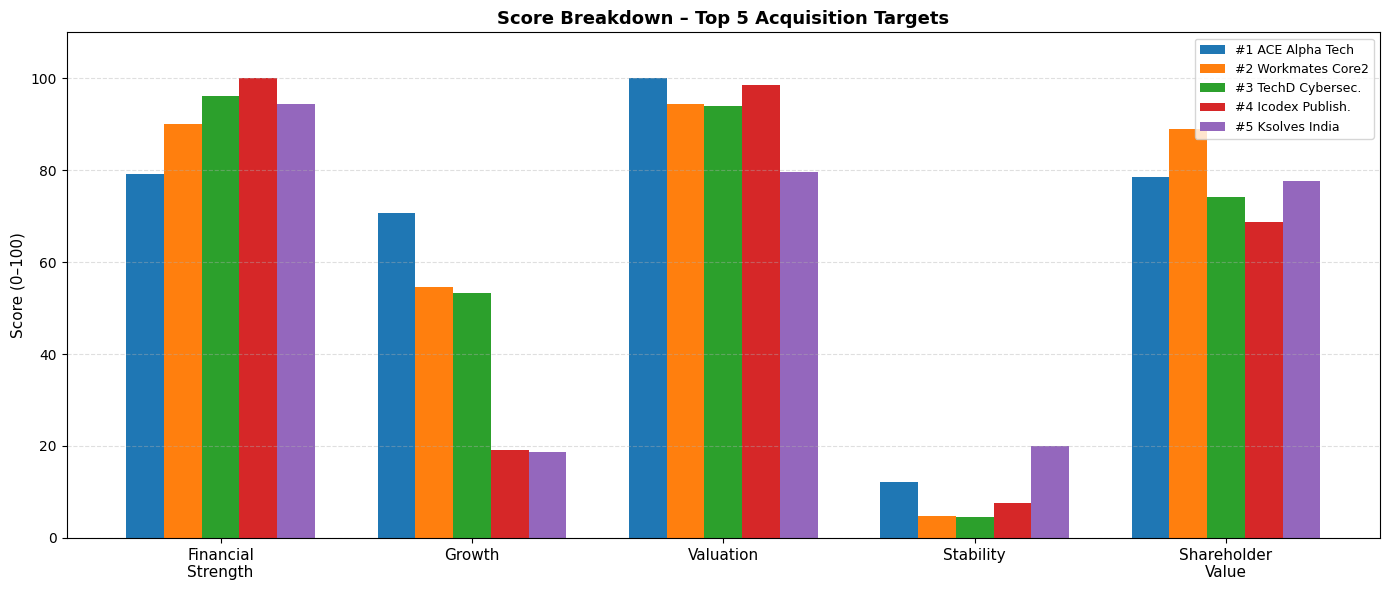

Chart saved: top5_score_breakdown.png

STEP 12: Exporting Results
Exported 56 companies to: acquisition_targets_ranked.csv

── Final Summary ──
Total companies in dataset    : 400
Companies after IT/Fintech    : 56
Scored & ranked               : 56

Top 3 Recommendations:
  #1 ACE Alpha Tech | Score: 71.11 | MCap: ₹156.3 Cr | Sector: IT - Software
  #2 Workmates Core2 | Score: 69.14 | MCap: ₹451.8 Cr | Sector: IT - Software
  #3 TechD Cybersec. | Score: 69.03 | MCap: ₹449.3 Cr | Sector: IT - Services

 Pipeline Complete. All outputs saved.


In [ ]:
# ============================================================
# AI-DRIVEN ACQUISITION TARGET RANKING MODEL
# For: Mid-Sized Indian IT Firm | Budget: ₹180 Cr
# Target Sectors: IT Services, IT Software, Fintech
# ============================================================

# ── IMPORTS ─────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from itertools import product

warnings.filterwarnings("ignore")

# ============================================================
# STEP 1 – LOAD DATA
# ============================================================
print("=" * 65)
print("STEP 1: Loading Data")
print("=" * 65)

df = pd.read_excel("https://raw.githubusercontent.com/MollyKhandelwal/ai-ma-acquisition-model/main/dataset.xlsx")

print(f"Raw dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:\n{df.head(3)}")

# Standardise column names (strip whitespace and non-breaking spaces)
df.columns = df.columns.str.replace('\xa0', ' ').str.strip()

# Map expected column names (adjust if actual names differ slightly)
COL_MAP = {
    "Name": "Name",
    "Sector": "Sector",
    "Mar Cap Rs.Cr.": "Mar_Cap",
    "P/E": "PE",
    "Div Yld %": "Div_Yld",
    "NP Qtr Rs.Cr.": "NP_Qtr",
    "Qtr Profit Var %": "Qtr_Profit_Var",
    "Sales Qtr Rs.Cr.": "Sales_Qtr",
    "Qtr Sales Var %": "Qtr_Sales_Var",
    "ROCE %": "ROCE",
    "OPM %": "OPM",
    "Sales Var 3Yrs %": "Sales_Var_3Y",
    "Profit Var 3Yrs %": "Profit_Var_3Y",
    "3Yrs return %": "Return_3Y",
    "ROE 3Yr %": "ROE_3Y",
    "EBIDT Var 3Yrs %": "EBIDT_Var_3Y",
    "EPS Var 3Yrs %": "EPS_Var_3Y",
}

df.rename(columns=COL_MAP, inplace=True)

NUMERIC_COLS = [
    "Mar_Cap", "PE", "Div_Yld", "NP_Qtr", "Qtr_Profit_Var",
    "Sales_Qtr", "Qtr_Sales_Var", "ROCE", "OPM",
    "Sales_Var_3Y", "Profit_Var_3Y", "Return_3Y",
    "ROE_3Y", "EBIDT_Var_3Y", "EPS_Var_3Y",
]

for col in NUMERIC_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(f"\nData loaded successfully. Shape: {df.shape}")

# ============================================================
# STEP 2 – DATA CLEANING & ACQUISITION FILTERS
# ============================================================
print("\n" + "=" * 65)
print("STEP 2: Applying Acquisition Filters")
print("=" * 65)

TARGET_SECTORS = ["IT - Services", "IT - Software", "Fintech"]

before = len(df)

df_filtered = df[
    (df["Mar_Cap"] <= 1000) &
    (df["NP_Qtr"] > 0) &
    (df["ROCE"] >= 5) &
    (df["OPM"] >= 5) &
    (df["Sales_Var_3Y"] > 0) &
    (df["Profit_Var_3Y"] > 0) &
    (df["Sector"].isin(TARGET_SECTORS))
].copy()

print(f"Companies before filtering : {before}")
print(f"Companies after filtering  : {len(df_filtered)}")
print(f"\nSector distribution after filter:\n{df_filtered['Sector'].value_counts()}")

# ============================================================
# STEP 3 – HANDLE MISSING VALUES
# ============================================================
print("\n" + "=" * 65)
print("STEP 3: Imputing Missing Values")
print("=" * 65)

missing_before = df_filtered[NUMERIC_COLS].isnull().sum()
print(f"Missing values before imputation:\n{missing_before[missing_before > 0]}")

# Sector-wise median imputation
for col in NUMERIC_COLS:
    df_filtered[col] = df_filtered.groupby("Sector")[col].transform(
        lambda x: x.fillna(x.median())
    )

# Global median fallback
global_medians = df_filtered[NUMERIC_COLS].median()
df_filtered[NUMERIC_COLS] = df_filtered[NUMERIC_COLS].fillna(global_medians)

missing_after = df_filtered[NUMERIC_COLS].isnull().sum().sum()
print(f"Missing values after imputation: {missing_after}")

# ============================================================
# STEP 4 – OUTLIER TREATMENT (WINSORIZE 5th–95th percentile)
# ============================================================
print("\n" + "=" * 65)
print("STEP 4: Winsorizing Outliers (5th–95th percentile)")
print("=" * 65)

df_clean = df_filtered.copy()

for col in NUMERIC_COLS:
    df_clean[col] = winsorize(df_clean[col].values, limits=[0.05, 0.05])

print("Winsorization applied to all numeric columns.")

# ============================================================
# STEP 5 – FEATURE ENGINEERING
# ============================================================
print("\n" + "=" * 65)
print("STEP 5: Feature Engineering – Composite Raw Scores")
print("=" * 65)

# ── Financial Strength Score (ROCE 40%, ROE_3Y 40%, OPM 20%)
df_clean["Financial_Strength_Raw"] = (
    0.40 * df_clean["ROCE"] +
    0.40 * df_clean["ROE_3Y"] +
    0.20 * df_clean["OPM"]
)

# ── Growth Score (equal weight across 4 vars)
df_clean["Growth_Raw"] = (
    0.25 * df_clean["Sales_Var_3Y"] +
    0.25 * df_clean["Profit_Var_3Y"] +
    0.25 * df_clean["EPS_Var_3Y"] +
    0.25 * df_clean["EBIDT_Var_3Y"]
)

# ── Stability Score (inverse of absolute quarterly variance)
# Higher stability = lower absolute variance
eps = 1e-6  # avoid division by zero
df_clean["Stability_Raw"] = 1 / (
    0.5 * (df_clean["Qtr_Profit_Var"].abs() + eps) +
    0.5 * (df_clean["Qtr_Sales_Var"].abs() + eps)
)

# ── Valuation Score (PEG = P/E / Profit_Var_3Y; lower is better)
# We'll invert after normalization; compute raw PEG first
df_clean["PEG_Raw"] = df_clean["PE"] / (df_clean["Profit_Var_3Y"] + eps)
# We store as negative so that higher score = lower PEG = better valuation
df_clean["Valuation_Raw"] = -df_clean["PEG_Raw"]

# ── Shareholder Value Score (3Y return 50%, ROE_3Y 50%)
df_clean["Shareholder_Raw"] = (
    0.50 * df_clean["Return_3Y"] +
    0.50 * df_clean["ROE_3Y"]
)

print("Composite raw scores computed.")
print(df_clean[["Name", "Financial_Strength_Raw", "Growth_Raw",
                "Stability_Raw", "Valuation_Raw", "Shareholder_Raw"]].head())

# ============================================================
# STEP 6 – NORMALIZE SCORES (MinMax → 0–100)
# ============================================================
print("\n" + "=" * 65)
print("STEP 6: Normalizing Scores (0–100)")
print("=" * 65)

RAW_SCORE_COLS = [
    "Financial_Strength_Raw", "Growth_Raw",
    "Stability_Raw", "Valuation_Raw", "Shareholder_Raw"
]
NORM_SCORE_COLS = [c.replace("_Raw", "_Score") for c in RAW_SCORE_COLS]

scaler = MinMaxScaler(feature_range=(0, 100))
df_clean[NORM_SCORE_COLS] = scaler.fit_transform(df_clean[RAW_SCORE_COLS])

print("Normalized score statistics:")
print(df_clean[NORM_SCORE_COLS].describe().round(2))

# ============================================================
# STEP 7 – WEIGHTED FINAL SCORE
# ============================================================
print("\n" + "=" * 65)
print("STEP 7: Computing Weighted Final Score")
print("=" * 65)

WEIGHTS = {
    "Financial_Strength_Score": 0.30,
    "Growth_Score":             0.25,
    "Valuation_Score":          0.20,
    "Stability_Score":          0.15,
    "Shareholder_Score":        0.10,
}

df_clean["Final_Acquisition_Score"] = sum(
    df_clean[col] * w for col, w in WEIGHTS.items()
)

print("Final Acquisition Score computed.")
print(f"Score range: {df_clean['Final_Acquisition_Score'].min():.2f} – "
      f"{df_clean['Final_Acquisition_Score'].max():.2f}")

# ============================================================
# STEP 8 – RANKING
# ============================================================
print("\n" + "=" * 65)
print("STEP 8: Ranking Companies")
print("=" * 65)

df_clean["Rank"] = df_clean["Final_Acquisition_Score"].rank(
    ascending=False, method="min"
).astype(int)

df_ranked = df_clean.sort_values("Final_Acquisition_Score", ascending=False).reset_index(drop=True)

TOP10 = df_ranked.head(10).copy()
TOP5  = df_ranked.head(5).copy()

DISPLAY_COLS = [
    "Rank", "Name", "Sector", "Mar_Cap",
    "Final_Acquisition_Score",
    "Financial_Strength_Score", "Growth_Score",
    "Valuation_Score", "Stability_Score", "Shareholder_Score"
]

print("\n🏆 TOP 10 ACQUISITION TARGETS:")
print(TOP10[DISPLAY_COLS].to_string(index=False))

print("\n⭐ TOP 5 HIGHLIGHTED:")
print(TOP5[DISPLAY_COLS].to_string(index=False))

# ============================================================
# STEP 9 – EXPLAINABILITY FOR TOP 5
# ============================================================
print("\n" + "=" * 65)
print("STEP 9: Explainability – Top 5 Detailed Breakdown")
print("=" * 65)

METRIC_COLS = [
    "Mar_Cap", "PE", "NP_Qtr", "ROCE", "OPM",
    "Sales_Var_3Y", "Profit_Var_3Y", "EPS_Var_3Y",
    "EBIDT_Var_3Y", "Return_3Y", "ROE_3Y",
    "Qtr_Profit_Var", "Qtr_Sales_Var", "PEG_Raw"
]

GLOBAL_MEDIANS_CLEAN = {col: df_clean[col].median() for col in METRIC_COLS}

STRENGTH_THRESHOLDS = {
    "ROCE": 15, "OPM": 15, "ROE_3Y": 15,
    "Sales_Var_3Y": 15, "Profit_Var_3Y": 15,
    "Return_3Y": 20,
}
REDFLAG_THRESHOLDS = {
    "PE": 50,           # very high PE
    "Qtr_Profit_Var": 30,   # high quarterly variance
    "Qtr_Sales_Var": 30,
    "PEG_Raw": 3,       # expensive relative to growth
}

for i, row in TOP5.iterrows():
    rank = row["Rank"]
    print(f"\n{'─'*60}")
    print(f"  #{rank} | {row['Name']}  ({row['Sector']})")
    print(f"{'─'*60}")
    print(f"  Final Score         : {row['Final_Acquisition_Score']:.2f} / 100")
    print(f"  Market Cap          : ₹{row['Mar_Cap']:.1f} Cr")
    print(f"\n  ── Composite Scores ──")
    print(f"  Financial Strength  : {row['Financial_Strength_Score']:.2f}  (wt 30%)")
    print(f"  Growth              : {row['Growth_Score']:.2f}  (wt 25%)")
    print(f"  Valuation           : {row['Valuation_Score']:.2f}  (wt 20%)")
    print(f"  Stability           : {row['Stability_Score']:.2f}  (wt 15%)")
    print(f"  Shareholder Value   : {row['Shareholder_Score']:.2f}  (wt 10%)")
    print(f"\n  ── Key Metrics ──")
    for col in METRIC_COLS:
        val   = row[col]
        med   = GLOBAL_MEDIANS_CLEAN[col]
        delta = "▲" if val > med else "▼"
        print(f"  {col:<22}: {val:>10.2f}   (median: {med:.2f}) {delta}")

    # Strengths
    strengths = []
    for col, thr in STRENGTH_THRESHOLDS.items():
        if row[col] >= thr:
            strengths.append(f"{col} = {row[col]:.1f}%")
    if row["PEG_Raw"] < 1:
        strengths.append(f"Attractive PEG = {row['PEG_Raw']:.2f}")
    print(f"\n  ✅ STRENGTHS  : {', '.join(strengths) if strengths else 'None flagged'}")

    # Red flags
    red_flags = []
    for col, thr in REDFLAG_THRESHOLDS.items():
        if row[col] > thr:
            red_flags.append(f"{col} = {row[col]:.1f} (>{thr})")
    if row["NP_Qtr"] < 5:
        red_flags.append(f"Low quarterly profit ₹{row['NP_Qtr']:.1f} Cr")
    print(f"  🚩 RED FLAGS  : {', '.join(red_flags) if red_flags else 'None flagged'}")

# ============================================================
# STEP 10 – SENSITIVITY ANALYSIS (±5% weight variation)
# ============================================================
print("\n" + "=" * 65)
print("STEP 10: Sensitivity Analysis – Weight Variation ±5%")
print("=" * 65)

BASE_WEIGHTS = {
    "Financial_Strength_Score": 0.30,
    "Growth_Score":             0.25,
    "Valuation_Score":          0.20,
    "Stability_Score":          0.15,
    "Shareholder_Score":        0.10,
}

DELTA = 0.05
variations = [(-DELTA, +DELTA), (+DELTA, -DELTA), (0, 0)]

base_top5_names = TOP5["Name"].tolist()

sensitivity_results = []

# We perturb pairs: (Financial_Strength ↔ Growth), (Valuation ↔ Stability)
perturb_pairs = [
    ("Financial_Strength_Score", "Growth_Score"),
    ("Financial_Strength_Score", "Valuation_Score"),
    ("Growth_Score", "Stability_Score"),
    ("Valuation_Score", "Shareholder_Score"),
]

for col_a, col_b in perturb_pairs:
    for sign_a, sign_b in [(-DELTA, +DELTA), (+DELTA, -DELTA)]:
        w = dict(BASE_WEIGHTS)
        w[col_a] = round(BASE_WEIGHTS[col_a] + sign_a, 2)
        w[col_b] = round(BASE_WEIGHTS[col_b] + sign_b, 2)

        # normalise to sum=1 in case of floating-point drift
        total = sum(w.values())
        w = {k: v / total for k, v in w.items()}

        temp_score = sum(df_clean[col] * wt for col, wt in w.items())
        temp_rank  = temp_score.rank(ascending=False, method="min")
        new_top5   = df_clean.loc[temp_score.nlargest(5).index, "Name"].tolist()

        same_count = len(set(base_top5_names) & set(new_top5))
        sensitivity_results.append({
            "Perturbed +": col_a if sign_a > 0 else col_b,
            "Perturbed -": col_b if sign_a > 0 else col_a,
            "Top5 Overlap": same_count,
            "Stable?": "✅ Yes" if same_count >= 4 else "⚠️ Partial",
            "New Top5": ", ".join(new_top5),
        })

sens_df = pd.DataFrame(sensitivity_results)
print(sens_df[["Perturbed +", "Perturbed -", "Top5 Overlap", "Stable?"]].to_string(index=False))
print(f"\nBase Top 5: {base_top5_names}")
print("\nDetailed sensitivity scenarios:")
for _, r in sens_df.iterrows():
    print(f"  +{r['Perturbed +']} / -{r['Perturbed -']}: "
          f"overlap={r['Top5 Overlap']}/5  {r['Stable?']}")
    print(f"    New Top5: {r['New Top5']}")

# ============================================================
# STEP 11 – VISUALIZATION
# ============================================================
print("\n" + "=" * 65)
print("STEP 11: Generating Visualizations")
print("=" * 65)

SECTOR_COLORS = {
    "IT - Services": "#4C72B0",
    "IT - Software": "#DD8452",
    "Fintech":       "#55A868",
}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("AI-Driven Acquisition Target Analysis\nMid-Sized Indian IT Firm | Budget ≤ ₹180 Cr",
             fontsize=14, fontweight="bold", y=1.01)

# ── Plot 1: Bar chart – Top 10 Final Scores
ax1 = axes[0]
bar_colors = [SECTOR_COLORS.get(s, "#999999") for s in TOP10["Sector"]]
bars = ax1.barh(
    TOP10["Name"][::-1],
    TOP10["Final_Acquisition_Score"][::-1],
    color=bar_colors[::-1], edgecolor="white", linewidth=0.5
)

# Highlight top 5 with a border
for i, (bar, name) in enumerate(zip(bars, TOP10["Name"][::-1])):
    rank = TOP10.loc[TOP10["Name"] == name, "Rank"].values[0]
    if rank <= 5:
        bar.set_edgecolor("#FFD700")
        bar.set_linewidth(2.5)
    ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.1f}", va="center", fontsize=9)

ax1.set_xlabel("Final Acquisition Score (0–100)", fontsize=11)
ax1.set_title("Top 10 Acquisition Targets\n(Gold border = Top 5)", fontsize=12)
ax1.set_xlim(0, 110)
ax1.grid(axis="x", linestyle="--", alpha=0.4)

legend_patches = [mpatches.Patch(color=v, label=k) for k, v in SECTOR_COLORS.items()]
ax1.legend(handles=legend_patches, loc="lower right", fontsize=9)

# ── Plot 2: Sector distribution of filtered candidates
ax2 = axes[1]
sector_counts = df_clean["Sector"].value_counts()
wedge_colors  = [SECTOR_COLORS.get(s, "#999999") for s in sector_counts.index]

wedges, texts, autotexts = ax2.pie(
    sector_counts.values,
    labels=sector_counts.index,
    autopct="%1.1f%%",
    colors=wedge_colors,
    startangle=140,
    pctdistance=0.80,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5}
)
for at in autotexts:
    at.set_fontsize(10)
    at.set_fontweight("bold")

ax2.set_title(f"Sector Distribution of\nFiltered Candidates (n={len(df_clean)})", fontsize=12)

plt.tight_layout()
plt.savefig("acquisition_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved: acquisition_analysis.png")

# ── Score breakdown radar-style bar for Top 5
fig2, ax3 = plt.subplots(figsize=(14, 6))

score_cols  = ["Financial_Strength_Score", "Growth_Score",
               "Valuation_Score", "Stability_Score", "Shareholder_Score"]
score_labels = ["Financial\nStrength", "Growth", "Valuation", "Stability", "Shareholder\nValue"]

x = np.arange(len(score_labels))
width = 0.15
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for j, (_, row) in enumerate(TOP5.iterrows()):
    vals = [row[c] for c in score_cols]
    ax3.bar(x + j * width, vals, width, label=f"#{row['Rank']} {row['Name']}", color=palette[j])

ax3.set_xticks(x + width * 2)
ax3.set_xticklabels(score_labels, fontsize=11)
ax3.set_ylabel("Score (0–100)", fontsize=11)
ax3.set_title("Score Breakdown – Top 5 Acquisition Targets", fontsize=13, fontweight="bold")
ax3.legend(fontsize=9, loc="upper right")
ax3.set_ylim(0, 110)
ax3.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("top5_score_breakdown.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart saved: top5_score_breakdown.png")

# ============================================================
# STEP 12 – EXPORT RESULTS
# ============================================================
print("\n" + "=" * 65)
print("STEP 12: Exporting Results")
print("=" * 65)

EXPORT_COLS = [
    "Rank", "Name", "Sector", "Mar_Cap", "PE", "NP_Qtr",
    "ROCE", "OPM", "ROE_3Y", "Sales_Var_3Y", "Profit_Var_3Y",
    "EPS_Var_3Y", "EBIDT_Var_3Y", "Return_3Y",
    "Qtr_Profit_Var", "Qtr_Sales_Var", "PEG_Raw",
    "Financial_Strength_Score", "Growth_Score",
    "Valuation_Score", "Stability_Score", "Shareholder_Score",
    "Final_Acquisition_Score"
]

df_export = df_ranked[EXPORT_COLS].copy()
df_export.to_csv("acquisition_targets_ranked.csv", index=False)

print(f"Exported {len(df_export)} companies to: acquisition_targets_ranked.csv")
print("\n── Final Summary ──")
print(f"Total companies in dataset    : {len(df)}")
print(f"Companies after IT/Fintech    : {len(df_filtered)}")
print(f"Scored & ranked               : {len(df_ranked)}")
print(f"\nTop 3 Recommendations:")
for _, row in df_ranked.head(3).iterrows():
    print(f"  #{int(row['Rank'])} {row['Name']} | Score: {row['Final_Acquisition_Score']:.2f} | "
          f"MCap: ₹{row['Mar_Cap']:.1f} Cr | Sector: {row['Sector']}")

print("\n Pipeline Complete. All outputs saved.")